# Plasmids MILP experiment v3

## Description

The following describes the experiment with iterative Plasmids assembly MILP with additional constraints to remove cycles. The plasmids obtained in this experiment have exactly one component each and the component is a path. This has been achieved by adding two types of constraints:
1. The number of contigs in the plasmid should be exactly one more than the number of links in the plasmid.
2. However, the first constraint can also be satisfied by graphs with multiple component containing exactly 1 path and the rest as cycles. Hence, we add constraints to remove any cyclic sequence of contigs in the plasmid. The resulting plasmid will contain exactly one path. 
As the number of cycles generated can be exponential, we add the second type of constraints iteratively as we identify a cyclic sequence. So, for instance, for a plasmid $p$, let $\{a,b,c,d\}$ be contigs involved in a cycle and $\{a_hb_h,b_tc_t,c_hd_t,d_ha_t\}$ be the links in the cycle, we add exactly one constraint:

links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] $\leq$ 3

If the number of such constraints is greater than 50 (which seems to happen frequently), the linearization is performed greedily removing the least weighted link in each remaining cycle. 

The details of the objective function are provided in modified_formulation.ipynb.

In addition to these constraints, we also separate questionable plasmids away from putative plasmids. The conditions under which a plasmid is classified as putative are as follows:

1. min_gene_density[plasmid] $\geq$ 0.3
2. min_gene_density[seed_contig] $\geq$ 1.5$*$min_gene_density[plasmid] $=$ 0.45
3. 1500 $\leq$ min_length[plasmid] $\leq$ 1750000

In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Figure 1: Linearization to obtain single component

In [3]:
#Image(filename="linearization.png", width=600)

In [46]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.switch_backend('agg')
%matplotlib inline

In [47]:
output_dir = '../output'
greedy_dir = '../../../../Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'
v2_dir = '../../2019-03-21__iterative_MILP_v2/output'

In [48]:
def update_dict(line, stat_dict, file, folder_loc):
    stat = line.split(" ")[-1]
    stat_dict[file.split('/')[folder_loc]].append(float(stat))
    return stat_dict

In [49]:
def compute_mean(mean, k, precs, recs, f1s):
    mean[k] = {}
    mean[k]['precision'] = sum(precs[k])/len(precs[k])
    mean[k]['recall'] = sum(recs[k])/len(recs[k])
    mean[k]['f1_score'] = sum(f1s[k])/len(f1s[k])
    return mean

In [50]:
def compute_max(best, k, precs, recs, f1s):
    best[k] = {}
    best[k]['precision'] = max(precs[k])
    best[k]['recall'] = max(recs[k])
    best[k]['f1_score'] = max(f1s[k])
    return best

## Statistics for different samples

In this part, we use the $\alpha$ ratios 1.1.1 as in the greedy heuristic. The MILP was run with nplasmids  $=1$. In other words, although we remove one plasmid at a time in this experiment, the MILP has provisions to remove $k>$1 plasmids in one iteration, provided convergence is reached. The main motivation behind the iterative plasmid generation approach is to help in reaching convergence by reducing the number of variables.

A set of 10 ids was chosen to test the general performance of the MILP. These were the same ids as in the previous experiments.

The results for the 10 chosen sample ids have been compared with the results of the greedy heuristic by Robert. The results of the greedy heuristic can be found at '/Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'.

In [51]:
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if "eval.csv" in f]
precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

for file in files:
    if 'sample' in file.split('/')[2]:
        sample_id = file.split('/')[2].split('_')[1]
        ratio = file.split('/')[3]
        with open(file, 'r') as f:
            for line in f:
                if "precision" in line:
                    precs = update_dict(line, precs, file, 2)
                    prec_ratio = update_dict(line, prec_ratio, file, 3)
                if "recall" in line:
                    recs = update_dict(line, recs, file, 2)
                    rec_ratio = update_dict(line, rec_ratio, file, 3)
                if "f1" in line:
                    f1s = update_dict(line, f1s, file, 2)
                    f1_ratio = update_dict(line, f1_ratio, file, 3)

In [52]:
mean, best = {}, {}
mean_scores, best_scores = [], [] 
for sample_id in precs:
    mean[sample_id] = {}
    mean[sample_id]['precision'] = sum(precs[sample_id])/len(precs[sample_id])
    mean[sample_id]['recall'] = sum(recs[sample_id])/len(recs[sample_id])
    mean[sample_id]['f1_score'] = sum(f1s[sample_id])/len(f1s[sample_id])
    mean_scores.append([sample_id, mean[sample_id]['precision'], mean[sample_id]['recall'], mean[sample_id]['f1_score']])

    best[sample_id] = {}
    best[sample_id]['precision'] = max(precs[sample_id])
    best[sample_id]['recall'] = max(recs[sample_id])
    best[sample_id]['f1_score'] = max(f1s[sample_id])  
    best_scores.append([sample_id, best[sample_id]['precision'], best[sample_id]['recall'], best[sample_id]['f1_score']])

mean_scores = pd.DataFrame(mean_scores)
mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

best_scores = pd.DataFrame(best_scores)
best_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 1: Average scores for each sample

In [53]:
mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.912488,0.629921,0.745321
1,sample_125,0.999980,0.668654,0.801423
2,sample_66,0.963247,0.464169,0.626460
3,sample_103,0.582142,0.887455,0.703084
4,sample_39,0.862257,0.889925,0.875873
5,sample_109,0.701633,0.544846,0.613379
6,sample_117,0.999149,0.731716,0.844773
7,sample_116,0.000000,0.000000,0.000000
8,sample_11,0.752657,0.691582,0.720828
9,sample_23,0.221225,0.813233,0.347829


#### Table 2: Maximum scores for each sample

In [54]:
best_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.912488,0.629921,0.745321
1,sample_125,0.999980,0.668654,0.801423
2,sample_66,0.963247,0.464169,0.626460
3,sample_103,0.582142,0.887455,0.703084
4,sample_39,0.862257,0.889925,0.875873
5,sample_109,0.701633,0.544846,0.613379
6,sample_117,0.999149,0.731716,0.844773
7,sample_116,0.000000,0.000000,0.000000
8,sample_11,0.752657,0.691582,0.720828
9,sample_23,0.221225,0.813233,0.347829


In [55]:
ids = mean_scores['Sample'].values.tolist()
greedy_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(greedy_dir) for f in filenames if "greedy_mean.csv" in f]
greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)

count = {}
for file in greedy_files:
    if file.split('/')[9] in ids:
        with open(file, 'r') as f:
            rl, pl, fl = [], [], []
            for line in f:
                if "score_ref_coverage" in line:
                    rl.append(line)
                if "score_pred_coverage" in line:
                    pl.append(line)
                if "overall_score" in line:
                    fl.append(line)       
            greedy_recs = update_dict(rl[0], greedy_recs, file, 9)
            greedy_precs = update_dict(pl[0], greedy_precs, file, 9)
            greedy_f1s = update_dict(fl[0], greedy_f1s, file, 9)

In [56]:
greedy_mean = {}
greedy_mean_scores = [] 
for sample_id in greedy_precs:
    greedy_mean[sample_id] = {}
    greedy_mean[sample_id]['precision'] = sum(greedy_precs[sample_id])/len(greedy_precs[sample_id])
    greedy_mean[sample_id]['recall'] = sum(greedy_recs[sample_id])/len(greedy_recs[sample_id])
    greedy_mean[sample_id]['f1_score'] = sum(greedy_f1s[sample_id])/len(greedy_f1s[sample_id])
    greedy_mean_scores.append([sample_id, greedy_mean[sample_id]['precision'], greedy_mean[sample_id]['recall'], greedy_mean[sample_id]['f1_score']])

greedy_mean_scores = pd.DataFrame(greedy_mean_scores)
greedy_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 3:Mean scores using greedy heuristic

In [57]:
greedy_mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,1.000000,0.976956,0.988478
1,sample_125,1.000000,0.996320,0.998160
2,sample_66,1.000000,1.000000,1.000000
3,sample_103,0.580096,0.900643,0.740370
4,sample_39,0.908497,0.915360,0.911929
5,sample_109,1.000000,0.983308,0.991655
6,sample_117,0.999994,0.989847,0.994921
7,sample_116,1.000000,0.324472,0.662236
8,sample_11,0.862581,0.954005,0.908293
9,sample_23,0.609916,1.000000,0.804958


In [58]:
v2_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(v2_dir) for f in filenames if "eval.csv" in f]
v2_precs, v2_recs, v2_f1s = defaultdict(list), defaultdict(list), defaultdict(list)
#prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

for file in v2_files:
    if 'sample' in file.split('/')[4]:
        sample_id = file.split('/')[4].split('_')[1]
        #print(sample_id, file)
        ratio = file.split('/')[3]
        with open(file, 'r') as f:
            for line in f:
                if "precision" in line:
                    v2_precs = update_dict(line, precs, file, 2)
                    #prec_ratio = update_dict(line, prec_ratio, file, 3)
                if "recall" in line:
                    v2_recs = update_dict(line, recs, file, 2)
                    #rec_ratio = update_dict(line, rec_ratio, file, 3)
                if "f1" in line:
                    v2_f1s = update_dict(line, f1s, file, 2)
                    #f1_ratio = update_dict(line, f1_ratio, file, 3)

In [59]:
v2_mean = {}
v2_mean_scores = [] 
for sample_id in v2_precs:
    if 'sample' in sample_id:
        #print(sample_id)
        v2_mean[sample_id] = {}
        v2_mean[sample_id]['precision'] = sum(v2_precs[sample_id])/len(v2_precs[sample_id])
        v2_mean[sample_id]['recall'] = sum(v2_recs[sample_id])/len(v2_recs[sample_id])
        v2_mean[sample_id]['f1_score'] = sum(v2_f1s[sample_id])/len(v2_f1s[sample_id])
        v2_mean_scores.append([sample_id, v2_mean[sample_id]['precision'], v2_mean[sample_id]['recall'], v2_mean[sample_id]['f1_score']])

v2_mean_scores = pd.DataFrame(v2_mean_scores)
v2_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)
#v2_mean_scores

#### Figure 2: Average precision

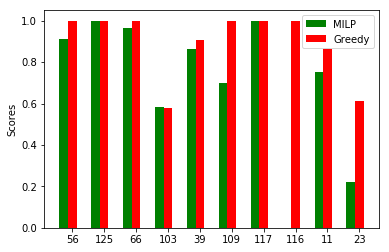

In [61]:
N = 10
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

pvals = mean_scores['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
gpvals = greedy_mean_scores['Precision'].values.tolist()
rects3 = axp.bar(ind+width, gpvals, width, color='r')
#v2pvals = v2_mean_scores['Precision'].values.tolist()
#rects2 = axp.bar(ind+2*width, v2pvals, width, color='b')

#axp.set_title('Figure 1: Average precision')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
#axp.legend( (rects1[0], rects2[0], rects3[0]), ('MILP', 'MILP v2', 'Greedy') )
axp.legend( (rects1[0], rects3[0]), ('MILP', 'Greedy') )
plt.show()

From Figures 2,3 and 4, it is clear that the greedy strategy consistently outperforms the MILP strategy once again. However, the performance has improved from previous experiments barring a couple of inputs. The average precision has improved with the exception of sample 109. No putative plasmids were output for sample 116. A common observation in this experiment was that the MILP output several short plasmids that made up a longer reference plasmid. Longer plasmids had very low gene density due to which they were considered as questionable.

#### Figure 3: Average recall

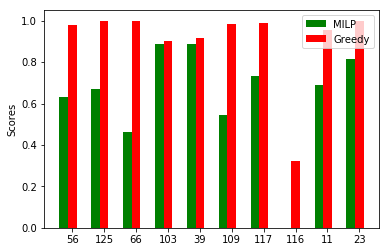

In [62]:
N = 10
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axr = fig.add_subplot(111)

rvals = mean_scores['Recall'].values.tolist()
rects4 = axr.bar(ind, rvals, width, color='g')
grvals = greedy_mean_scores['Recall'].values.tolist()
rects6 = axr.bar(ind+width, grvals, width, color='r')
#v2rvals = v2_mean_scores['Recall'].values.tolist()
#rects5 = axp.bar(ind+2*width, v2rvals, width, color='b')

#axr.set_title('Figure 2: Average recall')
axr.set_ylabel('Scores')
axr.set_xticks(ind+width)
axr.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
axr.legend( (rects4[0], rects6[0]), ('MILP', 'Greedy') )

plt.show()

#### Figure 4: Average F1 score

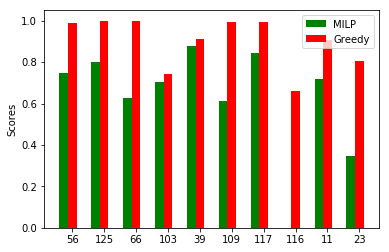

In [64]:
N = 10
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axf = fig.add_subplot(111)


fvals = mean_scores['F1 score'].values.tolist()
rects7 = axf.bar(ind, fvals, width, color='g')
gfvals = greedy_mean_scores['F1 score'].values.tolist()
rects9 = axf.bar(ind+width, gfvals, width, color='r')
#v2fvals = v2_mean_scores['F1 score'].values.tolist()
#rects8 = axf.bar(ind+2*width, v2fvals, width, color='b')

#axf.set_title('Figure 3: Average F1 score')
axf.set_ylabel('Scores')
axf.set_xticks(ind+width)
axf.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
axf.legend( (rects7[0], rects9[0]), ('MILP', 'Greedy') )

plt.show()

#### Figure 4: Best precision, recall and F1 score

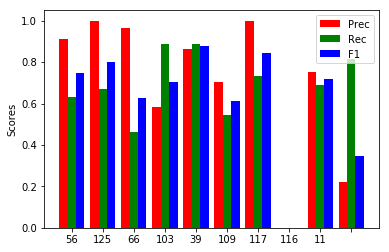

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)

pvals = best_scores['Precision'].values.tolist()
rects1 = ax.bar(ind, pvals, width, color='r')
rvals = best_scores['Recall'].values.tolist()
rects2 = ax.bar(ind+width, rvals, width, color='g')
fvals = best_scores['F1 score'].values.tolist()
rects3 = ax.bar(ind+width*2, fvals, width, color='b')
ids = best_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]
#ax.set_title('Figure 4: Best precision, recall and F1 score')
ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]) )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Prec', 'Rec', 'F1') )
plt.show()
plt.savefig(os.path.join(output_dir,'best_scores_MILP_exp-1.pdf'), format = 'pdf', dpi = 1200, bbox_inches = 'tight')